# Simulation with single vehicle. 

This demo is for the case passing a single heavy vehicle over a bridge, to check the corresponding maximum effect. 

The bridge: 

- Has two 3.5m-width lanes. 
- Has a length of 20m.
- Has a width of 9m.
- Has two load effects being considered (they are the same for simplification, mid-span BM). 

The vehicle:

- Has 3 axles, with axle weights of 100kN, 100kN and 100kN.
- Has axle spacings of 3m, 7m and 0m (the rear axle). 
- Has axle widths of 2m, 2m and 2m.

---

Import packages:

In [1]:
import pybtls as pb
from pathlib import Path

The bridge is simply supported with a span of 20m.

Set the first load effect by using a 2D influence surface. 

Here, we fake a influence surface in pyramidal shape, with the peak at the mid point of the bridge. 

In [2]:
IS_matrix = [
    [0.0, 0.0, 4.5, 9.0],
    [0.0, 0.0, 0.0, 0.0],
    [10.0, 5.0, 5.0, 5.0],
    [20.0, 0.0, 0.0, 0.0],
]

Then, we define two lanes on the bridge by giving their boundary positions in the bridge transverse direction. 

In [3]:
lanes_position = [(0.5, 4.0), (5.0, 8.5)]  # 1m gap between lane 1 and lane 2.

Now, we create a load effect from the influence surface and the lane positions. 

In [4]:
load_effect_1 = pb.InfluenceSurface()
load_effect_1.set_IS(IS_matrix, lanes_position)

Here we define another load effect, but this time we are using influence lines. 

The proposed load effect here is the mid-span bending moment. 

For lane 1, a set of discrete points is used to create a user-defined influence line.

For lane 2, the corresponding built-in influence line is used. 

In [5]:
load_effect_2_lane_1 = pb.InfluenceLine("discrete")
load_effect_2_lane_1.set_IL(position=[0.0, 10.0, 20.0], ordinate=[0.0, 5.0, 0.0])

load_effect_2_lane_2 = pb.InfluenceLine("built-in")
load_effect_2_lane_2.set_IL(type=1, length=20.0)

We create a bridge object and add the two load effects to it. 

In [6]:
bridge = pb.Bridge(length=20.0, no_lane=2)
bridge.add_load_effect(inf_line_surf=load_effect_1)
bridge.add_load_effect(inf_line_surf=[load_effect_2_lane_1, load_effect_2_lane_2])

Create the vehicle! 

In [7]:
vehicle = pb.Vehicle(no_axles=3)
vehicle.set_axle_weights([100.0, 100.0, 100.0])  # in kN
vehicle.set_axle_spacings([3.0, 7.0, 0.0])  # in m
vehicle.set_axle_widths([2.0, 2.0, 2.0])  # in m

Create the simulation task. 

The simulation object can automatically detect the simulation type based on what user inputted in add_sim(). 

We want to check how much load effects the bridge will experience when the vehicle passes over it.

The vehicle will pass the pridge on the specified active lane two times with different driving directions. 

Just to show that pybtls can do multiprocessing, we create two simulation tasks and run them in parallel.

In [8]:
sim_task = pb.Simulation(Path(".") / "temp")
sim_task.add_sim(
    bridge=bridge, vehicle=vehicle, active_lane=[1], tag="Case1-Lane1"
)  # vehicle passes lane 1
sim_task.add_sim(
    bridge=bridge, vehicle=vehicle, active_lane=[2], tag="Case1-Lane2"
)  # vehicle passes lane 2

# run simulation simultaneously
sim_task.run(no_core=2)


Bridge 20 m: Flushing AllEvents buffer: 1 events at 1/1/0 0:0:0	
Bridge 20 m: Flushing AllEvents buffer: 1 events at 1/1/0 0:0:0	
Bridge 20 m: Flushing AllEvents buffer: 1 events at 1/1/0 0:0:0	
Bridge 20 m: Flushing AllEvents buffer: 1 events at 1/1/0 0:0:0	

Get the output. 

The output is a dictionary with the keys being same as the tags of the simulation tasks.

In [9]:
sim_output = sim_task.get_output()

# See what data we have.
print(sim_output.keys())

dict_keys(['Case1-Lane1', 'Case1-Lane2'])


Further check what is included in the 'Case1-Lane1' output. 

Also, how many files are included in the specified 'time_history' output.

In [10]:
print(sim_output["Case1-Lane1"].get_summary())

TH_dict = sim_output["Case1-Lane1"].read_data("time_history")
print(TH_dict.keys())

['time_history', 'all_events']
dict_keys(['dir1', 'dir2'])


Check and visualize the Case1-Lane1 output. (You can do the same for the Case1-Lane2.)

,Time (s),No. Trucks,Effect 1,Effect 2
0,0.00,1,0.0,0.0
1,0.01,1,0.5,0.5
2,0.02,1,1.0,1.0
3,0.03,1,1.5,1.5
4,0.04,1,2.0,2.0
...,...,...,...,...
2995,29.95,1,2.5,2.5
2996,29.96,1,2.0,2.0
2997,29.97,1,1.5,1.5
2998,29.98,1,1.0,1.0


,Time (s),No. Trucks,Effect 1,Effect 2
0,0.00,1,0.0,0.0
1,0.01,1,0.5,0.5
2,0.02,1,1.0,1.0
3,0.03,1,1.5,1.5
4,0.04,1,2.0,2.0
...,...,...,...,...
2995,29.95,1,2.5,2.5
2996,29.96,1,2.0,2.0
2997,29.97,1,1.5,1.5
2998,29.98,1,1.0,1.0


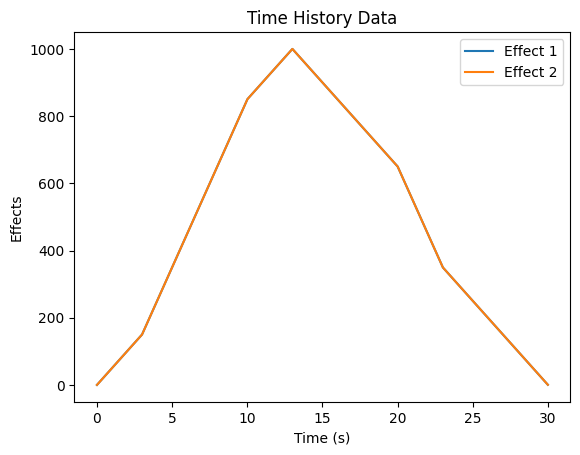

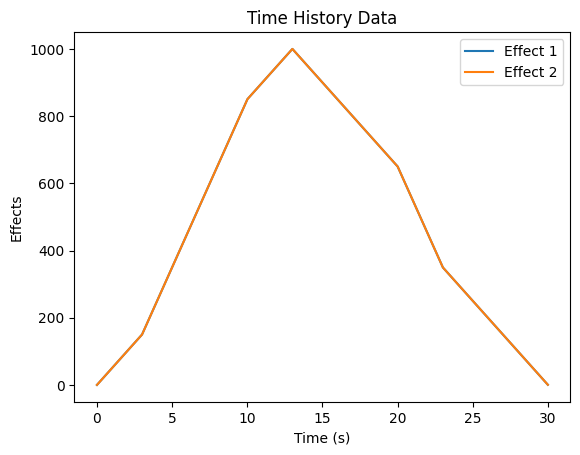

In [11]:
# Use display() to better show pd.DataFrame.
from IPython.display import display

display(TH_dict["dir1"])  # A pandas DataFrame
pb.Plot.plot_TH(data=TH_dict["dir1"], save_as="./temp/dir1_TH.png")

display(TH_dict["dir2"])  # A pandas DataFrame
pb.Plot.plot_TH(data=TH_dict["dir2"], save_as="./temp/dir2_TH.png")